In [1]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, SnapshotObjectType, OperationStatusType

In [2]:
import matplotlib.pyplot as plt

In [19]:
# Set the FACE_SUBSCRIPTION_KEY environment variable with your key as the value.
# This key will serve all examples in this document.
KEY = os.environ['FACE_SUBSCRIPTION_KEY']
# Set the FACE_ENDPOINT environment variable with the endpoint from your Face service in Azure.
# This endpoint will be used in all examples in this quickstart.
ENDPOINT = os.environ['FACE_ENDPOINT']

In [4]:
# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [5]:
os.listdir("/Volumes/GoogleDrive/Shared drives/Facefortrainning")

['17',
 '15',
 '4',
 '13',
 '12',
 '10',
 '3',
 '1',
 '2',
 '5',
 '6',
 '7',
 '8',
 '9',
 '11',
 '14',
 '16',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 'Icon\r']

In [13]:
PERSON_GROUP_ID = 'demo3'

In [29]:
face_client.person_group.delete(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

In [30]:
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

Person group: demo3


In [15]:
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [16]:
dict_user={}

In [34]:
dict_user

{'b5663c32-50d8-47cd-98b2-cd633ba4e5a2': '17',
 '1a540303-e69a-4c93-9bfa-ab3960c6580e': '15',
 '24c77cd1-bf67-44a6-8345-e46a26d4095c': '17',
 '4639437c-5319-4498-b91d-18848718025a': '15',
 'f60d0c77-d97c-4cf0-b3b5-4e64d03ee109': '17',
 '94bb4e91-b615-4692-bb42-7e9d99fd616d': '17',
 '27123291-fcb4-41dc-9905-0061a02f7a2d': '15',
 '752f8a95-8ff7-470f-9601-422ea0307f37': '17',
 '6d9ad337-433d-471e-aa09-bba7de71ba42': '15',
 'ea0ad98b-4437-42c2-8c07-c9713c423753': '4',
 'a343843a-474c-4a6d-9488-e63cbd5a93f5': '13',
 '07c394d5-5d5a-45cc-93ed-1532895c3156': '12',
 'f6b31dbe-f6bc-4e7a-b559-b1fe32238e0e': '12',
 '0ad86b07-72db-4820-b1ec-8994657b970a': '10',
 'c48aae2b-b4ff-4019-899a-ff5fafd45460': '3',
 '624eb04d-fc9f-4242-98c6-e8666ababf84': '1',
 '0748ce85-3d0a-4d2f-b75a-3ba16ebc875a': '2',
 'b18dd70e-55bc-41e2-a417-f5ca988db799': '5',
 '8ea518b0-32c1-433f-8f62-0239dd18823a': '6',
 '73ab8b1a-971f-4a35-8de9-7ae05ee1c96f': '7',
 'da0944e9-0e89-40f5-a4af-ec80d5707eb5': '8',
 '6a33b4fe-7d8b-42ae-

In [18]:
w = open(pathofphoto, 'r+b')
detected_faces = face_client.face.detect_with_stream(w)
time.sleep(10)

23
78 76 178 176


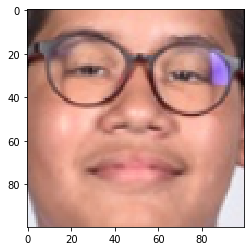

jpg
png


In [33]:
boo =True
for name in os.listdir("/Volumes/GoogleDrive/Shared drives/Facefortrainning"):
    if (name not in ['23']):
        continue
    dirofname="/Volumes/GoogleDrive/Shared drives/Facefortrainning/"+name
    print(name)
    person_group_person = face_client.person_group_person.create(PERSON_GROUP_ID, name)
    list_img=[]
    dict_user[person_group_person.person_id]=name
    for photo in os.listdir(dirofname):
        if(photo[-4:]!=".jpg" and photo[-4:]!=".png"):
            continue
        pathofphoto=dirofname+"/"+photo
        w = open(pathofphoto, 'r+b')
        
        boo=True
        while(boo):
            time.sleep(10)
            try:
                detected_faces = face_client.face.detect_with_stream(w)
                boo=False
            except Exception as e:
                print("except" ,e)
                time.sleep(10)
                continue
            
        if not detected_faces:
            print('No face detected from image')
            continue
        for face in detected_faces:
            ((left, top), (right, bottom))=getRectangle(face)
        print(left, top, right, bottom)
        img = Image.open(pathofphoto)
        img=img.crop((left, top, right, bottom))
        plt.imshow(img)
        plt.show()
        list_img.append(img)
    for i in list_img:
        
        try:
            print("jpg")
            i.save("temp.jpg")
            w = open("temp.jpg", 'r+b')
        except:
            print("png")
            i.save("temp.png")
            w = open("temp.png", 'r+b')
        
        boo=True
        while(boo):
            time.sleep(10)
            try:
                face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, person_group_person.person_id, w)
                boo=False
            except Exception as e:
                print("except 2",e)
                time.sleep(10)
                continue
        

In [36]:
'''
Train PersonGroup
'''
print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        sys.exit('Training the person group has failed.')
    time.sleep(5)


Training the person group...
Training status: running.

Training status: succeeded.



In [ ]:
'''
Identify a face against a defined PersonGroup
'''
# Group image for testing against
group_photo = 'test-image-person-group.jpg'
IMAGES_FOLDER = os.path.join(os.path.dirname(os.path.realpath("__file__")),"Officail_samples")

# Get test image
test_image_array = glob.glob(os.path.join(IMAGES_FOLDER, group_photo))
image = open(test_image_array[0], 'r+b')

# Detect faces
face_ids = []
faces = face_client.face.detect_with_stream(image)
for face in faces:
    face_ids.append(face.face_id)

In [ ]:
# Identify faces
results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
print('Identifying faces in {}'.format(os.path.basename(image.name)))
if not results:
    print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
for person in results:
    print('Person for face ID {} is identified in {} with a confidence of {}.'.format(person.face_id, os.path.basename(image.name), person.candidates[0].confidence)) # Get topmost confidence score